In [1]:
from typing import Iterable, Tuple, List, Callable
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.optimizers import Optimizer, Adam
from keras.metrics import Mean
from keras.layers import \
    Layer, Input, Conv2D, Conv2DTranspose

In [2]:
def generate_dataset(batch_size: int):
    (x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

    def preprocess_images(images):
        images = np.expand_dims(images, -1)
        return ((images / 255.0) - 0.5).astype(dtype=np.float32)

    def make_dataset(images, shuffle=False):
        dataset = tf.data.Dataset.from_tensor_slices(tensors=(images))
        dataset = dataset.map(lambda x: (x, x))
        dataset = dataset.shuffle(100) if shuffle else dataset
        return dataset.batch(batch_size)

    train_dataset = make_dataset(preprocess_images(x_train), shuffle=True)
    test_dataset = make_dataset(preprocess_images(x_test))
    return train_dataset, test_dataset

In [3]:
class VectorQuantizer(Layer):
    def __init__(self, num_embeddings: int, embedding_dim: int, name: str="vector_quantizer"):
        super().__init__(name=name)
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.embeddings = self._build_embeddings(num_embeddings, embedding_dim)

    def call(self, x: tf.Tensor):
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])
        closest_encoding_ids = self._most_similar_embeddings(flattened)
        categoricals = tf.one_hot(closest_encoding_ids, self.num_embeddings)
        quantized = tf.matmul(categoricals, self.embeddings, transpose_b=True)
        quantized = tf.reshape(quantized, input_shape)
        return quantized # TODO: think of returning categoricals as well

    def _most_similar_embeddings(self, inputs: tf.Tensor):
        # calculate distances as (inputs - embeds)^2
        inputs_sqsum = tf.reduce_sum(inputs ** 2, axis=1, keepdims=True)
        embed_sqsum = tf.reduce_sum(self.embeddings ** 2, axis=0)
        similarity = tf.matmul(inputs, self.embeddings)
        distances = inputs_sqsum + embed_sqsum - 2 * similarity
        return tf.argmin(distances, axis=1)

    def _build_embeddings(self, num_embeddings: int, embedding_dim: int):
        embed_shape = (self.embedding_dim, self.num_embeddings)
        w_init = tf.random_uniform_initializer()
        embed_w = w_init(shape=embed_shape, dtype=tf.float32)
        return tf.Variable(embed_w, True, name="embeddings_vqvae")

In [4]:
def create_encoder(latent_dim: int, input_shape: Iterable[int]):
    encoder_inputs = Input(shape=input_shape)
    conv_1 = Conv2D(32, (3, 3), activation="relu", strides=(2, 2), padding="same")
    conv_2 = Conv2D(64, (3, 3), activation="relu", strides=(2, 2), padding="same")
    conv_out = Conv2D(latent_dim, (1, 1), padding="same")
    encoder_outputs = conv_out(conv_2(conv_1(encoder_inputs)))
    return Model(encoder_inputs, encoder_outputs, name="encoder")


def create_decoder(input_shape: Iterable[int]):
    latent_inputs = Input(shape=input_shape)
    conv_1 = Conv2DTranspose(64, (3, 3), activation="relu", strides=(2, 2), padding="same")
    conv_2 = Conv2DTranspose(32, (3, 3), activation="relu", strides=(2, 2), padding="same")
    conv_out = Conv2DTranspose(1, (3, 3), padding="same")
    decoder_outputs = conv_out(conv_2(conv_1(latent_inputs)))
    return Model(latent_inputs, decoder_outputs, name="decoder")


def compose_vqvae(latent_dim: int, num_embeddings: int, input_shape: Iterable[int]):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim)
    encoder = create_encoder(latent_dim, input_shape)
    decoder = create_decoder(encoder.output.shape[1:])

    model_in = Input(shape=input_shape, name="img_orig")
    z_enc = encoder(model_in)
    z_quantized = vq_layer(z_enc)
    z_st_quantized = z_enc + tf.stop_gradient(z_quantized - z_enc)
    x_reconst = decoder(z_st_quantized)

    vqvae_train = Model(inputs=[model_in], outputs=[x_reconst, z_enc, z_quantized], name="vqvae")
    vqvae_infer = Model(inputs=[model_in], outputs=[x_reconst], name="vqvae")
    return vqvae_train, vqvae_infer


compose_vqvae(16, 64, (28, 28, 1))[1].summary()

Model: "vqvae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_orig (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           (None, 7, 7, 16)     19856       ['img_orig[0][0]']               
                                                                                                  
 vector_quantizer (VectorQuanti  (None, 7, 7, 16)    1024        ['encoder[0][0]']                
 zer)                                                                                             
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 7, 7, 16)     0           ['vector_quantizer[0][0]',   

In [5]:
TrainBatch = Tuple[tf.Tensor, tf.Tensor]


@tf.function
def train_step(
        model: Model, optimizer: Optimizer, batch: TrainBatch,
        train_variance: float=1.0, committment_cost: float=0.25):

    x, y_true = batch
    with tf.GradientTape() as tape:
        reconst, z_enc, z_quantized = model(x)

        commitment_loss = tf.reduce_mean((tf.stop_gradient(z_quantized) - z_enc) ** 2)
        codebook_loss = tf.reduce_mean((z_quantized - tf.stop_gradient(z_enc)) ** 2)
        vqvae_loss = committment_cost * commitment_loss + codebook_loss

        reconst_loss = tf.reduce_mean((y_true - reconst) ** 2) / train_variance
        total_loss = reconst_loss + vqvae_loss

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return vqvae_loss, reconst_loss, total_loss


class LossLogger:
    def __init__(self):
        self.vqvae_loss_mean = Mean()
        self.reconst_loss_mean = Mean()
        self.total_loss_mean = Mean()

    def log_losses(self, vqvae_loss, reconst_loss, total_loss):
        self.vqvae_loss_mean(vqvae_loss)
        self.reconst_loss_mean(reconst_loss)
        self.total_loss_mean(total_loss)

    def flush_losses(self, epoch: int):
        print((f"epoch {epoch}: "
               f"vqvae_loss={self.vqvae_loss_mean.result():.4f}, "
               f"reconst_loss={self.reconst_loss_mean.result():.4f}, "
               f"total_loss={self.total_loss_mean.result():.4f}"))
        self.vqvae_loss_mean.reset_state()
        self.reconst_loss_mean.reset_state()
        self.total_loss_mean.reset_state()
        

def train():
    epochs = 30
    model_train, model_infer = compose_vqvae(
        latent_dim=16, num_embeddings=128, input_shape=(28, 28, 1))
    optimizer = Adam()
    train_dataset, test_dataset = generate_dataset(batch_size=128)
    loss_logger = LossLogger()

    for ep in range(epochs):
        for batch in train_dataset:
            vqvae_loss, reconst_loss, total_loss = train_step(model_train, optimizer, batch)
            loss_logger.log_losses(vqvae_loss, reconst_loss, total_loss)
        loss_logger.flush_losses(ep+1)

    return model_infer

In [6]:
trained_vqvae_model = train()
# vqvae_loss: 0.0109, reconst_loss: 0.0030, total_loss: 0.0139

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
epoch 1: vqvae_loss=0.0473, reconst_loss=0.0301, total_loss=0.0774
epoch 2: vqvae_loss=0.0187, reconst_loss=0.0082, total_loss=0.0270
epoch 3: vqvae_loss=0.0160, reconst_loss=0.0065, total_loss=0.0224
epoch 4: vqvae_loss=0.0153, reconst_loss=0.0056, total_loss=0.0209
epoch 5: vqvae_loss=0.0148, reconst_loss=0.0051, total_loss=0.0199
epoch 6: vqvae_loss=0.0142, reconst_loss=0.0048, total_loss=0.0190
epoch 7: vqvae_loss=0.0141, reconst_loss=0.0045, total_loss=0.0186
epoch 8: vqvae_loss=0.0137, reconst_loss=0.0043, total_loss=0.0181
epoch 9: vqvae_loss=0.0134, reconst_loss=0.0042, total_loss=0.0176
epoch 10: vqvae_loss=0.0131, reconst_loss=0.0040, total_loss=0.0171
epoch 11: vqvae_loss=0.0128, reconst_loss=0.0039, total_loss=0.0167
epoch 12: vqvae_loss=0.0127, reconst_loss=0.0038, total_loss

2/2 [==============================] - 0s 48ms/step
(28, 28, 1) (28, 28, 1)


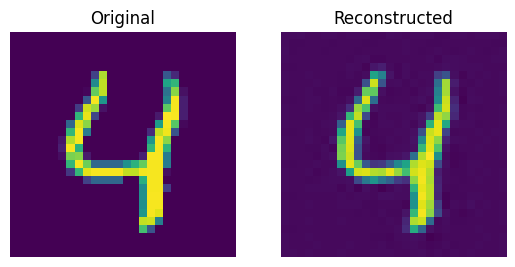

(28, 28, 1) (28, 28, 1)


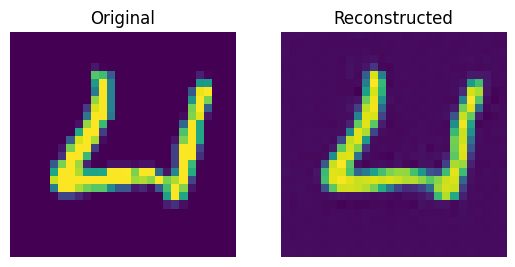

(28, 28, 1) (28, 28, 1)


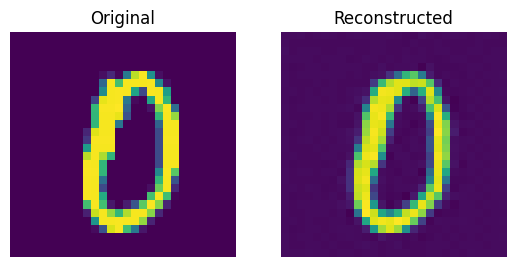

(28, 28, 1) (28, 28, 1)


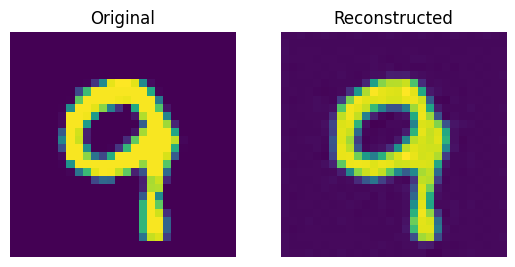

(28, 28, 1) (28, 28, 1)


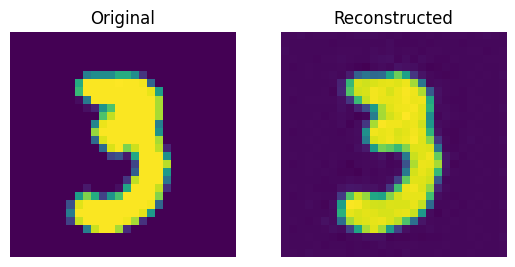

(28, 28, 1) (28, 28, 1)


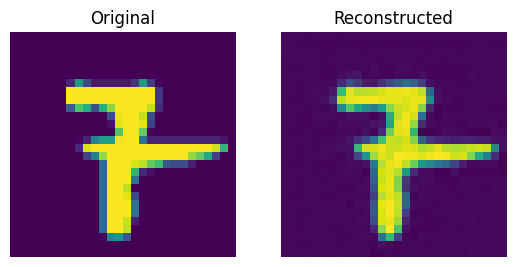

(28, 28, 1) (28, 28, 1)


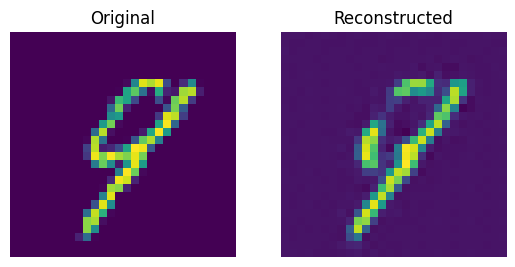

(28, 28, 1) (28, 28, 1)


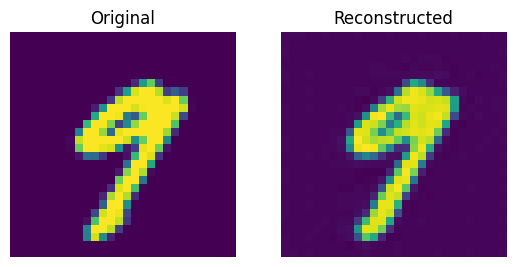

(28, 28, 1) (28, 28, 1)


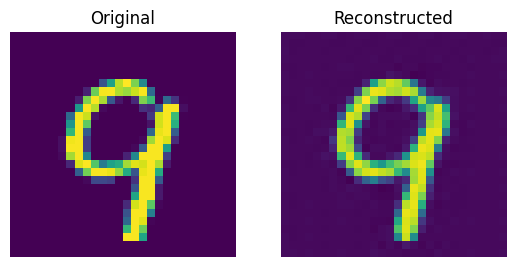

(28, 28, 1) (28, 28, 1)


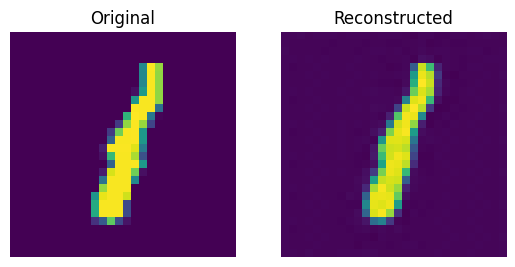

(28, 28, 1) (28, 28, 1)


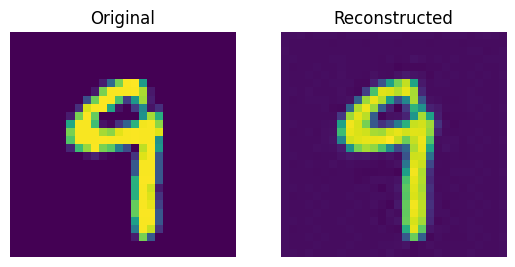

(28, 28, 1) (28, 28, 1)


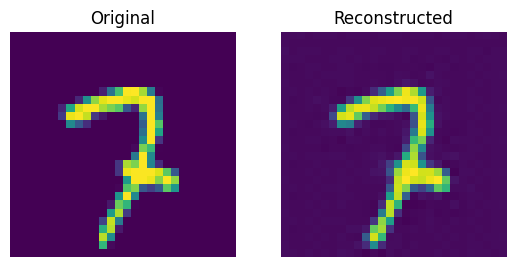

(28, 28, 1) (28, 28, 1)


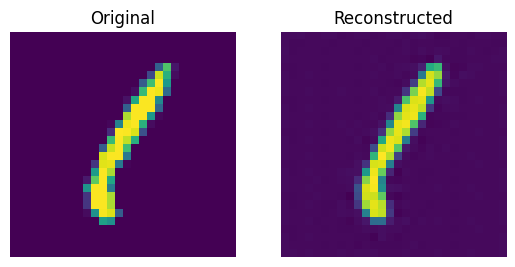

(28, 28, 1) (28, 28, 1)


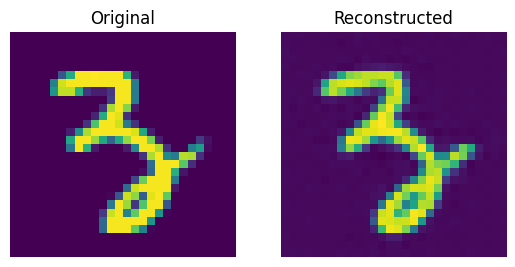

(28, 28, 1) (28, 28, 1)


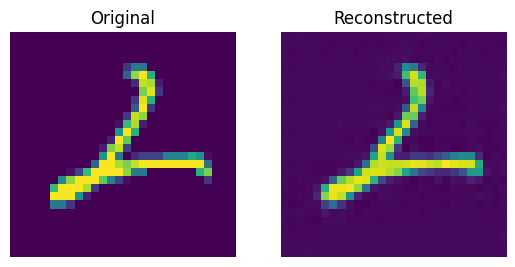

(28, 28, 1) (28, 28, 1)


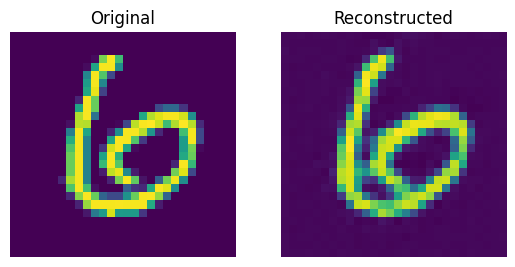

(28, 28, 1) (28, 28, 1)


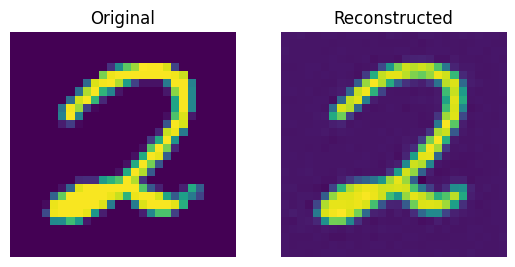

(28, 28, 1) (28, 28, 1)


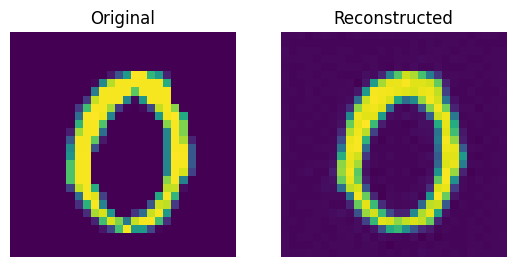

(28, 28, 1) (28, 28, 1)


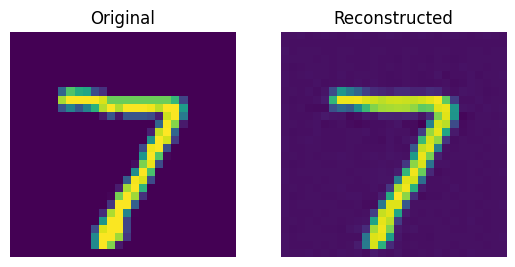

(28, 28, 1) (28, 28, 1)


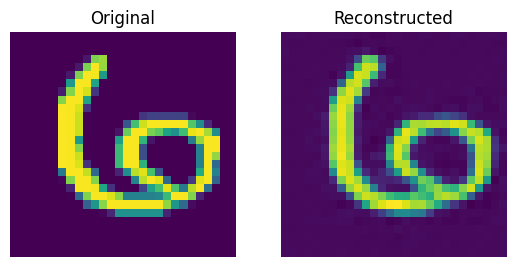

(28, 28, 1) (28, 28, 1)


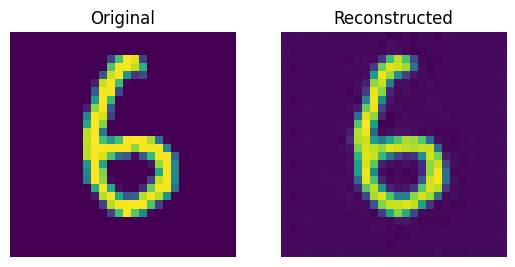

(28, 28, 1) (28, 28, 1)


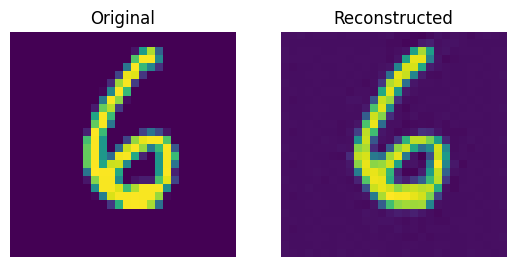

(28, 28, 1) (28, 28, 1)


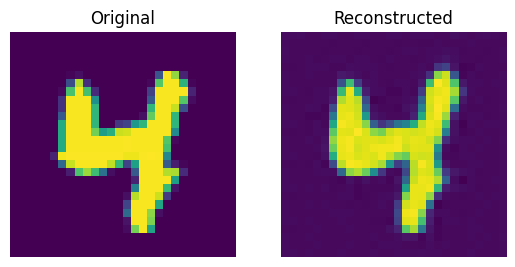

(28, 28, 1) (28, 28, 1)


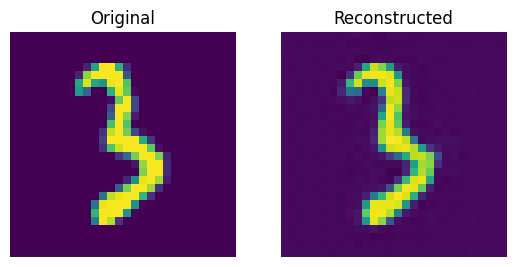

(28, 28, 1) (28, 28, 1)


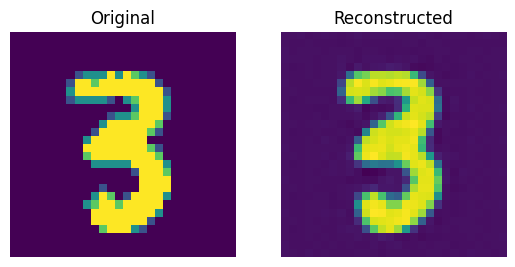

(28, 28, 1) (28, 28, 1)


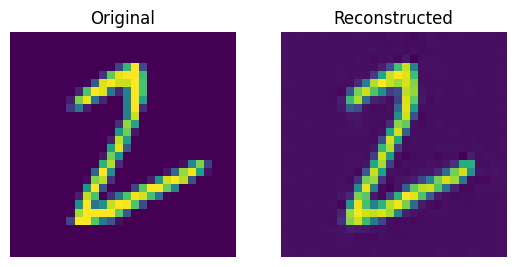

(28, 28, 1) (28, 28, 1)


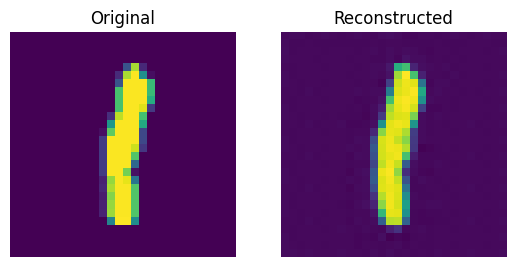

(28, 28, 1) (28, 28, 1)


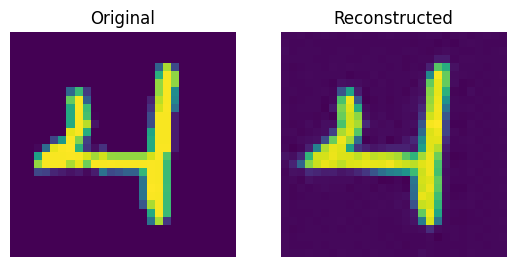

(28, 28, 1) (28, 28, 1)


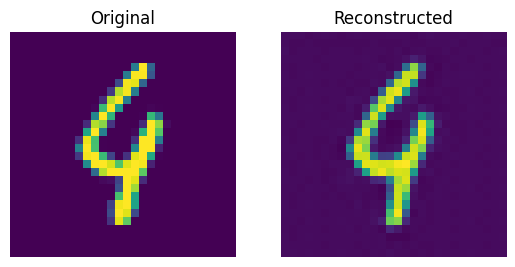

(28, 28, 1) (28, 28, 1)


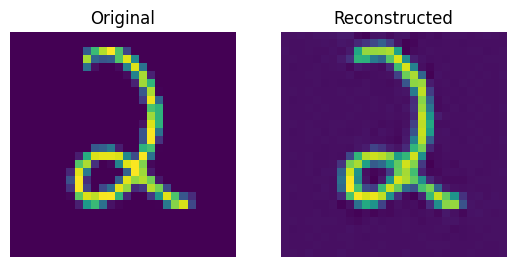

(28, 28, 1) (28, 28, 1)


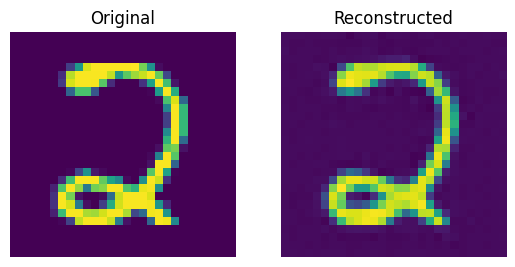

(28, 28, 1) (28, 28, 1)


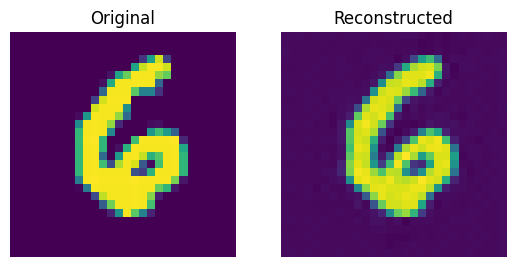

(28, 28, 1) (28, 28, 1)


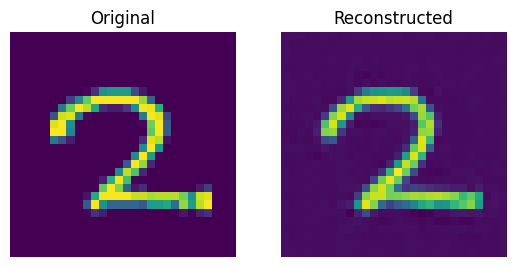

(28, 28, 1) (28, 28, 1)


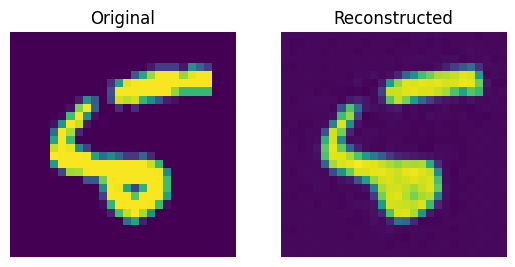

(28, 28, 1) (28, 28, 1)


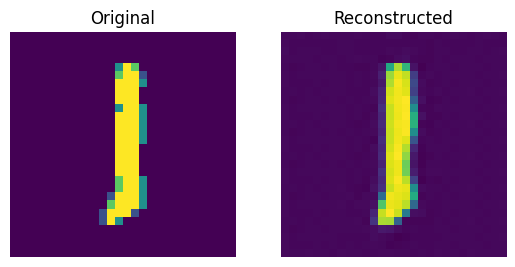

(28, 28, 1) (28, 28, 1)


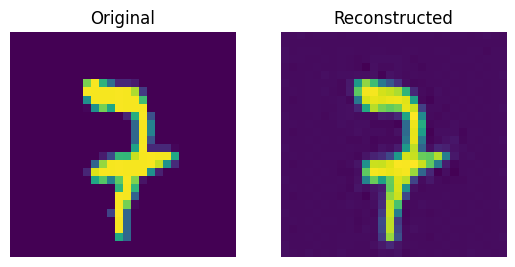

(28, 28, 1) (28, 28, 1)


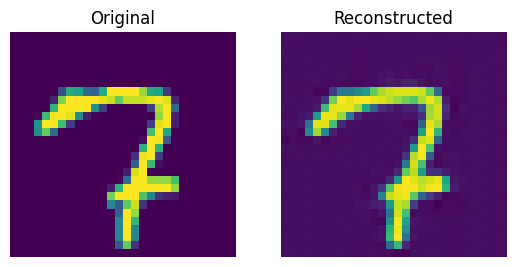

(28, 28, 1) (28, 28, 1)


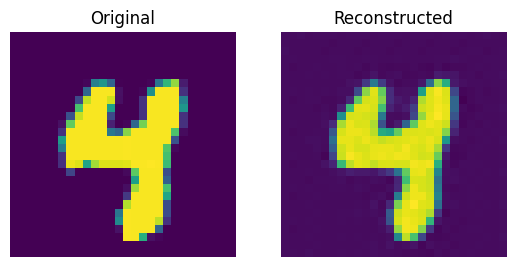

(28, 28, 1) (28, 28, 1)


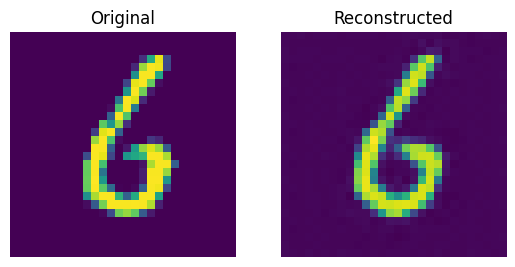

(28, 28, 1) (28, 28, 1)


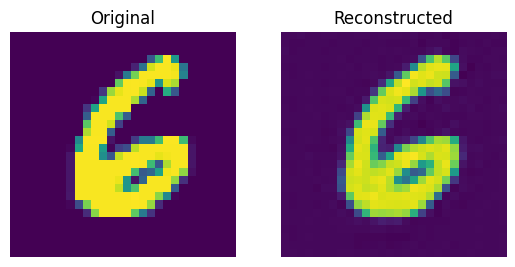

(28, 28, 1) (28, 28, 1)


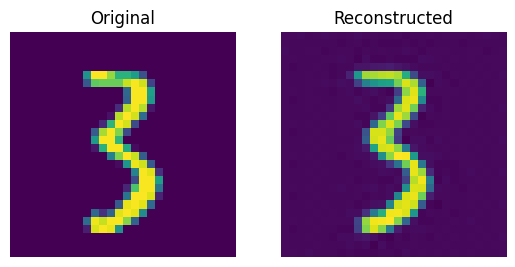

(28, 28, 1) (28, 28, 1)


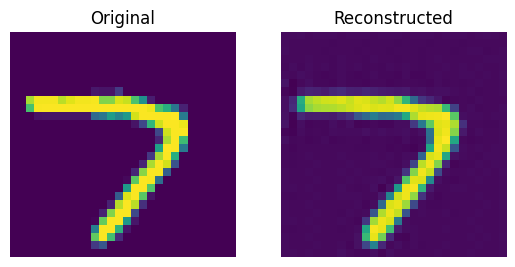

(28, 28, 1) (28, 28, 1)


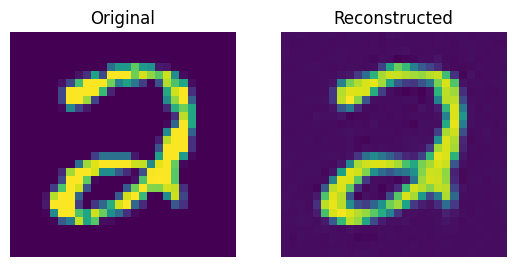

(28, 28, 1) (28, 28, 1)


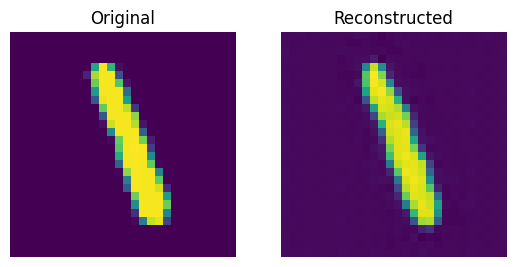

(28, 28, 1) (28, 28, 1)


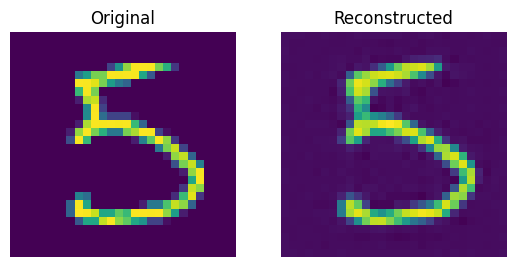

(28, 28, 1) (28, 28, 1)


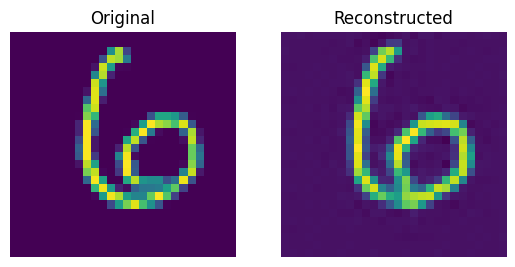

(28, 28, 1) (28, 28, 1)


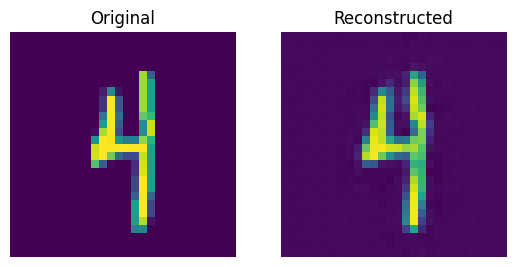

(28, 28, 1) (28, 28, 1)


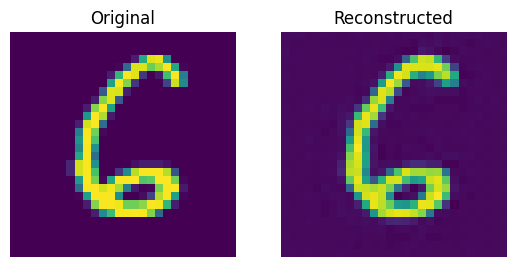

(28, 28, 1) (28, 28, 1)


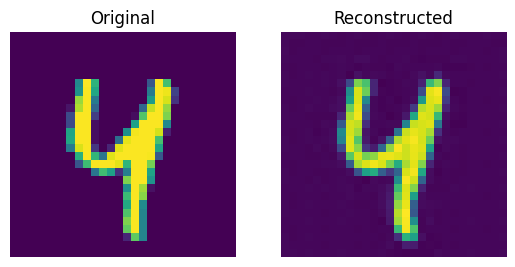

(28, 28, 1) (28, 28, 1)


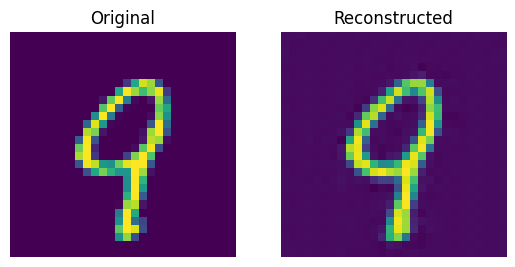

In [7]:
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


def eval_on_test_data(num_examples: int):
    _, test_dataset = generate_dataset(batch_size=128)
    test_batches = test_dataset.unbatch().shuffle(100).batch(num_examples)
    test_images = next(iter(test_batches.take(1)))[0].numpy()
    reconst_images = trained_vqvae_model.predict(test_images)

    for test_image, reconst_image in zip(test_images, reconst_images):
        print(test_image.shape, reconst_image.shape)
        show_subplot(test_image, reconst_image)


eval_on_test_data(50)